## Deepar

In [1]:
import json
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt
from itertools import islice
from gluonts.evaluation import Evaluator
import pandas as pd

/Users/interestingtj/miniforge3/envs/satcast/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
# Load JSONL into a list of dicts
with open("../data/processed/deepar_dataset.jsonl") as f:
    series_list = [json.loads(line) for line in f]


In [3]:
#subset 100 data points
s = series_list[0]
dataset = ListDataset(series_list, freq="15min")

In [6]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    prediction_length=96,
    context_length=96,
    freq="15min",
    lags_seq=[1, 2, 3, 6, 12, 24, 48, 96, 192],
    hidden_size=80,     # RNN cell size
    num_layers=3,       # Depth of the network
    dropout_rate=0.1,
    lr=1e-3,
    weight_decay=1e-8,
    batch_size=64,
    num_batches_per_epoch=50,
    trainer_kwargs={
        "max_epochs": 30,
        "accelerator": "cpu",
        "gradient_clip_val": 10.0,
        "logger": False,
    }
)


In [7]:
predictor = estimator.train(dataset)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/interestingtj/miniforge3/envs/satcast/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/interestingtj/miniforge3/envs/satcast/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/interestingtj/miniforge3/envs/satcast/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints exists and is not empty.

  | Name  | Type        | Params | Mode  | In sizes                                                      | Out sizes   
------------------------------------------------------------------------------------

Epoch 0: |          | 50/? [00:12<00:00,  4.10it/s, train_loss=1.260]

Epoch 0, global step 50: 'train_loss' reached 1.26379 (best 1.26379), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:12<00:00,  4.03it/s, train_loss=0.843]

Epoch 1, global step 100: 'train_loss' reached 0.84264 (best 0.84264), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:12<00:00,  4.01it/s, train_loss=0.682]

Epoch 2, global step 150: 'train_loss' reached 0.68220 (best 0.68220), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:12<00:00,  4.04it/s, train_loss=0.466]

Epoch 3, global step 200: 'train_loss' reached 0.46590 (best 0.46590), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:12<00:00,  4.01it/s, train_loss=0.260]

Epoch 4, global step 250: 'train_loss' reached 0.25977 (best 0.25977), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:12<00:00,  3.98it/s, train_loss=0.0798]

Epoch 5, global step 300: 'train_loss' reached 0.07979 (best 0.07979), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:12<00:00,  3.87it/s, train_loss=0.020] 

Epoch 6, global step 350: 'train_loss' reached 0.01997 (best 0.01997), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:12<00:00,  4.06it/s, train_loss=-0.093]

Epoch 7, global step 400: 'train_loss' reached -0.09299 (best -0.09299), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:12<00:00,  4.04it/s, train_loss=-0.121]

Epoch 8, global step 450: 'train_loss' reached -0.12054 (best -0.12054), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:12<00:00,  4.05it/s, train_loss=-0.16] 

Epoch 9, global step 500: 'train_loss' reached -0.15975 (best -0.15975), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:12<00:00,  3.99it/s, train_loss=0.277]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:12<00:00,  4.05it/s, train_loss=0.305]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:12<00:00,  3.99it/s, train_loss=0.0931]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:12<00:00,  4.05it/s, train_loss=-0.0314]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:12<00:00,  4.02it/s, train_loss=-0.0333]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:12<00:00,  4.00it/s, train_loss=-0.115] 

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:12<00:00,  4.05it/s, train_loss=-0.161]

Epoch 16, global step 850: 'train_loss' reached -0.16108 (best -0.16108), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:12<00:00,  3.94it/s, train_loss=-0.201]

Epoch 17, global step 900: 'train_loss' reached -0.20086 (best -0.20086), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:12<00:00,  3.96it/s, train_loss=-0.14] 

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:12<00:00,  4.00it/s, train_loss=-0.181]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:12<00:00,  3.98it/s, train_loss=-0.10] 

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:12<00:00,  4.02it/s, train_loss=0.00743]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:12<00:00,  4.01it/s, train_loss=-0.212] 

Epoch 22, global step 1150: 'train_loss' reached -0.21246 (best -0.21246), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:12<00:00,  3.99it/s, train_loss=-0.122]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:12<00:00,  4.02it/s, train_loss=-0.128]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:12<00:00,  4.03it/s, train_loss=-0.189]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:12<00:00,  3.97it/s, train_loss=-0.255]

Epoch 26, global step 1350: 'train_loss' reached -0.25518 (best -0.25518), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:12<00:00,  3.96it/s, train_loss=-0.22] 

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:12<00:00,  4.04it/s, train_loss=-0.25]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:12<00:00,  3.98it/s, train_loss=-0.292]

Epoch 29, global step 1500: 'train_loss' reached -0.29193 (best -0.29193), saving model to '/Users/interestingtj/Documents/mds/capstone_deepar/Capstone_SatCast_Trilemma/analysis/checkpoints/epoch=29-step=1500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: |          | 50/? [00:12<00:00,  3.97it/s, train_loss=-0.292]


In [8]:
# Evaluate
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=100
)
forecast_list = list(forecast_it)
ts_list = list(ts_it)

In [9]:

# Evaluation
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator([ts_list[1]], [forecast_list[1]])

# Print summary
print("\nAggregate Metrics:")
for k, v in agg_metrics.items():
    print(f"{k:>20}: {v:.4f}")


Running evaluation: 1it [00:00, 12.09it/s]



Aggregate Metrics:
                 MSE: 470.2497
           abs_error: 1521.9934
      abs_target_sum: 1666.0000
     abs_target_mean: 17.3542
      seasonal_error: 1.7787
                MASE: 8.9133
                MAPE: 0.7811
               sMAPE: 1.3104
                MSIS: 285.7610
num_masked_target_values: 0.0000
   QuantileLoss[0.1]: 317.9515
       Coverage[0.1]: 0.0104
   QuantileLoss[0.2]: 629.3241
       Coverage[0.2]: 0.0417
   QuantileLoss[0.3]: 934.9501
       Coverage[0.3]: 0.0625
   QuantileLoss[0.4]: 1233.5151
       Coverage[0.4]: 0.1146
   QuantileLoss[0.5]: 1521.9935
       Coverage[0.5]: 0.1458
   QuantileLoss[0.6]: 1796.6936
       Coverage[0.6]: 0.1458
   QuantileLoss[0.7]: 2048.4883
       Coverage[0.7]: 0.2083
   QuantileLoss[0.8]: 2269.0766
       Coverage[0.8]: 0.2500
   QuantileLoss[0.9]: 2431.5238
       Coverage[0.9]: 0.2708
                RMSE: 21.6852
               NRMSE: 1.2496
                  ND: 0.9136
  wQuantileLoss[0.1]: 0.1908
  wQuantileL

/Users/interestingtj/miniforge3/envs/satcast/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


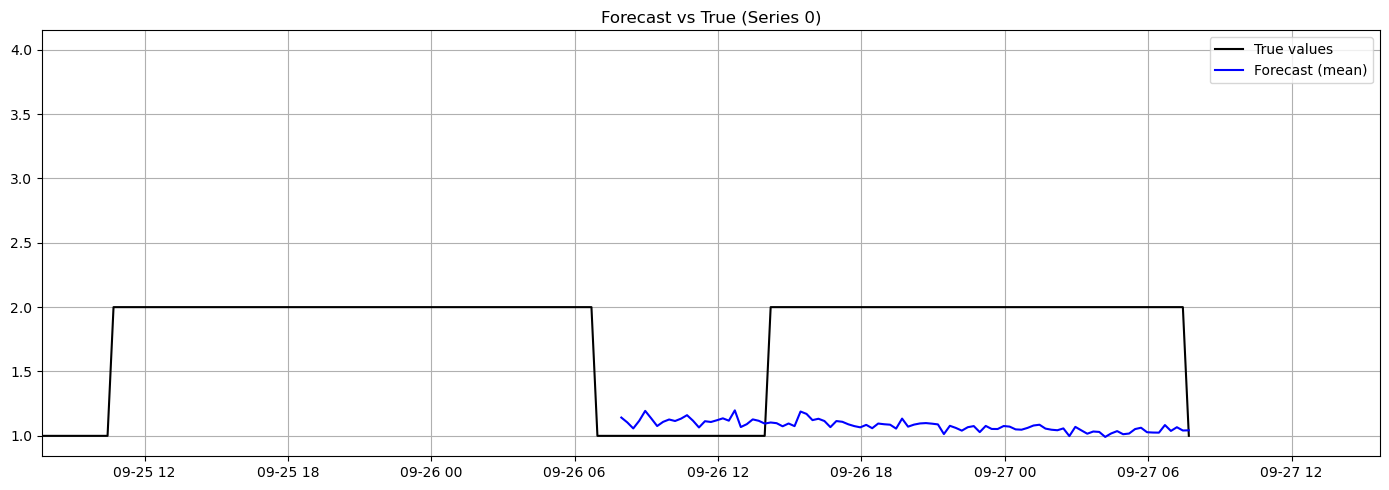

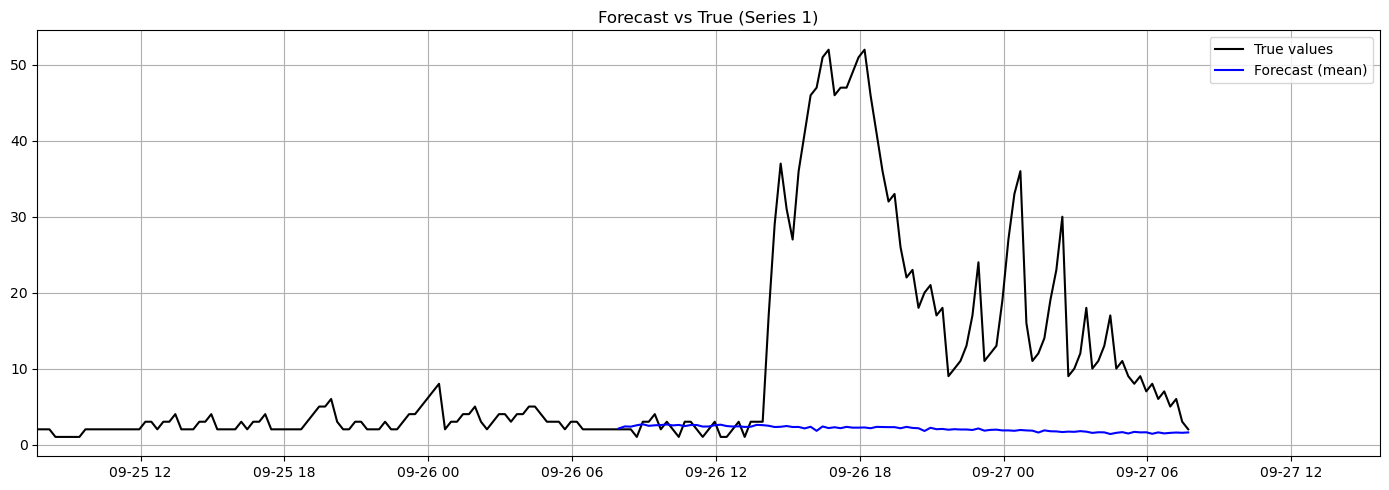

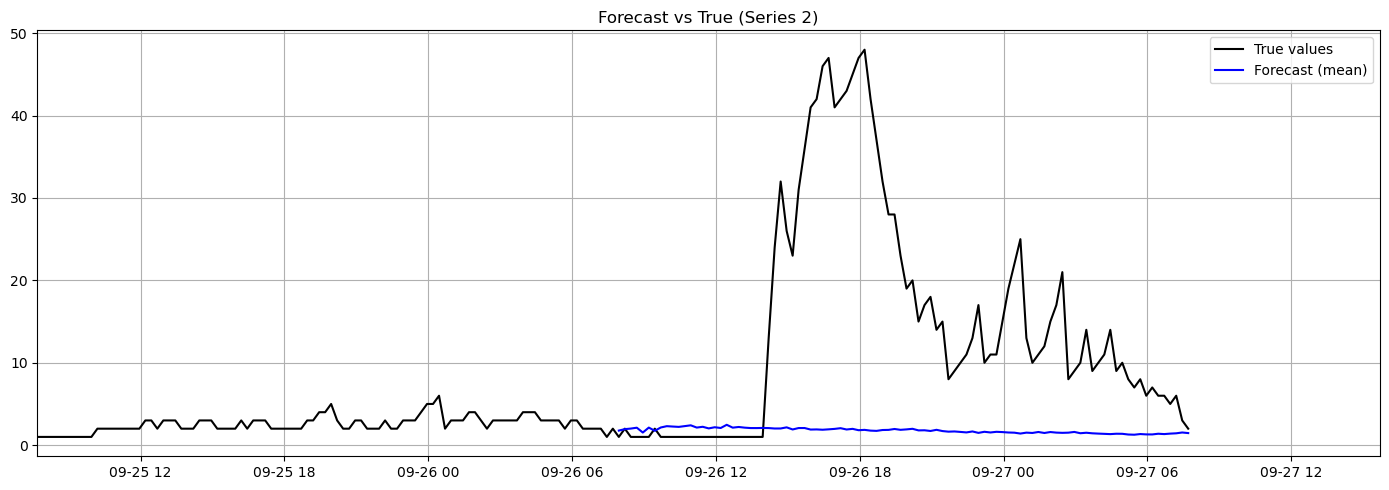

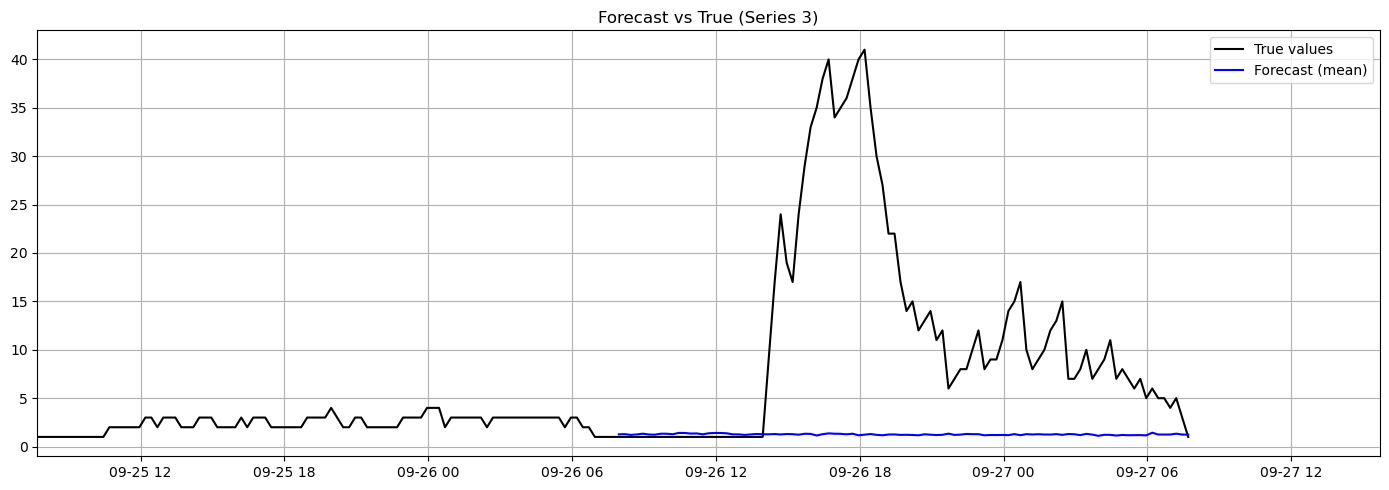

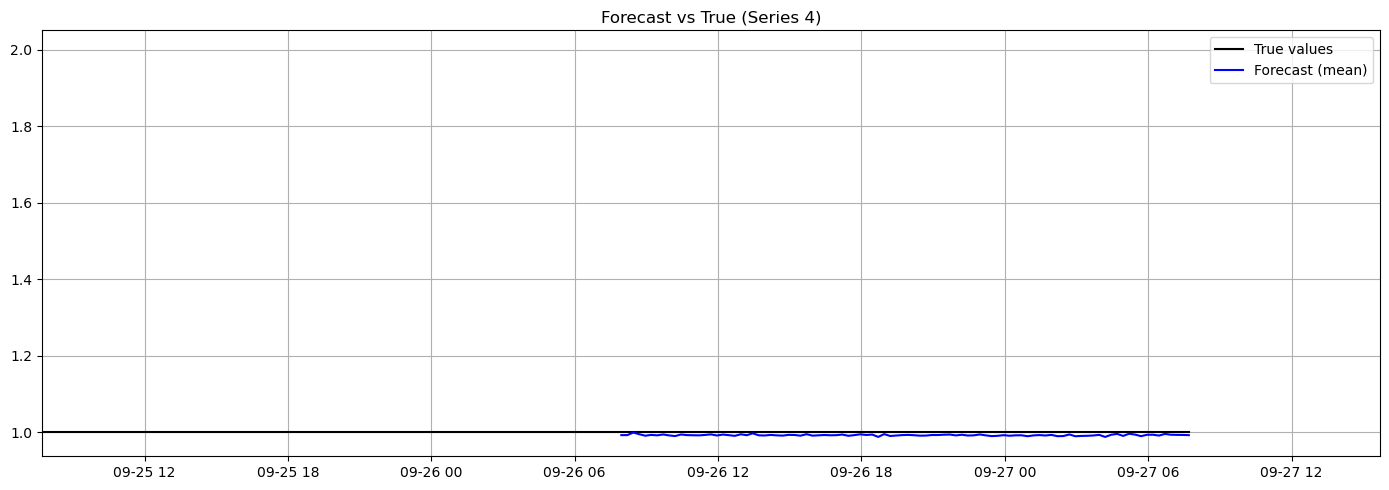

In [10]:
n_plots = len(forecast_list)  # or set a lower limit for visual clarity
for i in range(n_plots):
    ts = ts_list[i]
    forecast = forecast_list[i]

    # Convert PeriodIndex to Timestamp for plotting
    ts_index = ts.index.to_timestamp()

    # Forecast timestamps
    start = forecast.start_date.to_timestamp()
    freq = pd.Timedelta(forecast.freq)
    forecast_index = pd.date_range(start=start, periods=len(forecast.mean), freq=freq)

    # Determine x-axis limits (last 2 days)
    last_time = ts_index[-1]
    xlim_start = last_time - pd.Timedelta(days=2)
    xlim_end = last_time + pd.Timedelta(minutes=5 * len(forecast.mean))  # include forecast horizon

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(ts_index, ts.values, label="True values", color="black")
    plt.plot(forecast_index, forecast.mean, label="Forecast (mean)", color="blue")

    plt.title(f"Forecast vs True (Series {i})")
    plt.legend()
    plt.grid(True)
    plt.xlim(xlim_start, xlim_end)
    plt.tight_layout()
    plt.show()
